Вы получили основные навыки обработки данных, теперь пора испытать их на практике. Сейчас вам предстоит заняться задачей классификации.

Представлен датасет центра приюта животных, и вашей задачей будет обучить модель таким образом, чтобы  по определенным признакам была возможность максимально уверенно предсказать метки 'Adoption' и 'Transfer' (столбец “outcome_type”).

Здесь вы вольны делать что угодно. Я хочу видеть от вас:
1. Проверка наличия/обработка пропусков
2. Проверьте взаимосвязи между признаками
3. Попробуйте создать свои признаки
4. Удалите лишние
5. Обратите внимание на текстовые столбцы. Подумайте, что можно извлечь полезного оттуда
6. Использование профайлера вам поможет.
7. Не забывайте, что у вас есть PCA (Метод главных компонент). Он может пригодиться.

Вспомните о всем, что я говорил на предыдущих занятиях. Не все будет пригодится, но в жизни вам никто не будет говорить, что использовать :)

Хорошим классификатором для этой задачи будет "Случайный лес" (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Понимать суть работы "леса" не обязательно на данном этапе, но качество предсказаний будет выше, чем с линейным классификатором. (если желаете, вот гайд https://adataanalyst.com/scikit-learn/linear-classification-method/)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import re
from sklearn.ensemble import RandomForestClassifier

In [2]:
df =  pd.read_csv('aac_shelter_outcomes.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age_upon_outcome  78248 non-null  object
 1   animal_id         78256 non-null  object
 2   animal_type       78256 non-null  object
 3   breed             78256 non-null  object
 4   color             78256 non-null  object
 5   date_of_birth     78256 non-null  object
 6   datetime          78256 non-null  object
 7   monthyear         78256 non-null  object
 8   name              54370 non-null  object
 9   outcome_subtype   35963 non-null  object
 10  outcome_type      78244 non-null  object
 11  sex_upon_outcome  78254 non-null  object
dtypes: object(12)
memory usage: 7.2+ MB


In [4]:
df.shape

(78256, 12)

In [5]:
df.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
count,78248,78256,78256,78256,78256,78256,78256,78256,54370,35963,78244,78254
unique,46,70855,5,2128,525,5869,64361,64361,14574,19,9,5
top,1 year,A706536,Dog,Domestic Shorthair Mix,Black/White,2014-05-05T00:00:00,2016-04-18T00:00:00,2016-04-18T00:00:00,Bella,Partner,Adoption,Neutered Male
freq,14355,11,44242,23335,8153,112,39,39,344,19660,33112,27784


In [6]:
df.isnull().sum()

age_upon_outcome        8
animal_id               0
animal_type             0
breed                   0
color                   0
date_of_birth           0
datetime                0
monthyear               0
name                23886
outcome_subtype     42293
outcome_type           12
sex_upon_outcome        2
dtype: int64

In [7]:
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


### Наблюдения
1. Всё нужно перевести в скаляр за иисключением Transfer
2. Преобразовать пропущенные значения NaN, если возможно
3. Сравнить и при возможности удалить колонку datetime или monthyear
3. Вероятно удалить колонку name

### Сравню две колонки datetime и monthyear
Переведу их в числовой формат. Прежде вспомню, как это делать:

In [8]:
some_date = '2014-07-07T00:00:00'
dt.strptime(some_date, '%Y-%m-%dT%H:%M:%S' ) #формат выбрал именно этот на примере 2013-03-31T00:00:00 из кадра

datetime.datetime(2014, 7, 7, 0, 0)

In [9]:
def string_to_time(row):
    try:
        return dt.strptime(row, '%Y-%m-%dT%H:%M:%S' )
    except:
        return row        

In [10]:
df['date_of_birth'] = df['date_of_birth'].apply(string_to_time) # переведу до кучи, раз уж начал
df['datetime'] = df['datetime'].apply(string_to_time)
df['monthyear'] = df['monthyear'].apply(string_to_time)

In [11]:
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,2014-07-22 16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,2013-11-07 11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,2014-06-03 14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,2014-06-15 15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,2014-07-07 14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [12]:
(df['datetime'] - df['monthyear']).sum()

Timedelta('0 days 00:00:00')

#### А если разницы нет, тогда зачем платить больше

In [13]:
df.drop('monthyear', axis=1, inplace=True)

### Перевожу значения из age_upon_outcome в одну единицу - день

#### Заменяю nan значения

In [14]:
df.loc[df['age_upon_outcome'].isna(), :]

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,name,outcome_subtype,outcome_type,sex_upon_outcome
68246,NaN,A737705,Dog,Labrador Retriever Mix,Black/White,2013-11-02,2016-11-19 16:35:00,*Heddy,NaN,NaN,NaN
76825,NaN,A764319,Dog,Pit Bull Mix,Black/White,2016-12-27,2017-12-30 16:47:00,*Emma,NaN,NaN,Intact Female
77976,NaN,A765547,Bird,Leghorn Mix,White/Red,2017-01-22,2018-01-25 13:23:00,NaN,Partner,Transfer,Intact Female
78081,NaN,A765899,Dog,Miniature Poodle Mix,Black,2011-01-29,2018-01-29 15:49:00,NaN,Suffering,Euthanasia,Neutered Male
78114,NaN,A765914,Cat,Domestic Shorthair Mix,Lynx Point,2017-01-29,2018-01-29 18:08:00,NaN,Suffering,Euthanasia,Intact Male
78162,NaN,A765901,Dog,Maltese Mix,Buff,2017-01-29,2018-01-31 08:14:00,NaN,Partner,Transfer,Intact Male
78208,NaN,A765960,Dog,Beagle/Catahoula,Tan/White,2010-02-01,2018-02-01 09:21:00,NaN,Suffering,Euthanasia,Intact Male
78253,NaN,A766098,Other,Bat Mix,Brown,2017-02-01,2018-02-01 18:08:00,NaN,Rabies Risk,Euthanasia,Unknown


Поищу, а не было из в этом приюте ранее. Может быть есть закономерности. То есть сначала ищу все дубликаты в индексе, а затем среди них только те, где number = NaN

In [15]:
df[df.index.duplicated(keep=False)]['age_upon_outcome'].isna().all()

True

**age_upon_outcome** - это возраст на момент выхода из приюта. Можно эти значения заменить разницей выхода из приюта (datetime) и днём рождения (date_of_birth)

In [16]:
(df.loc[df['age_upon_outcome'].isna(), 'datetime'] - df.loc[df['age_upon_outcome'].isna(), 'date_of_birth']).dt.round('d').astype(str).head(10)

68246    1114 days
76825     369 days
77976     369 days
78081    2558 days
78114     366 days
78162     367 days
78208    2922 days
78253     366 days
dtype: object

In [17]:
df.loc[df['age_upon_outcome'].isna(), 'age_upon_outcome'] = \
(df.loc[df['age_upon_outcome'].isna(), 'datetime'] - df.loc[df['age_upon_outcome'].isna(), 'date_of_birth']) \
.dt.round('d').astype(str)

In [18]:
df.loc[df['age_upon_outcome'].isna(), :]

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,name,outcome_subtype,outcome_type,sex_upon_outcome


#### Теперь привожу возраст (age_upon_outcome)  к единой единице измерения - день
Для этого поделю на две колонки и заменю год множителем 365, месяц - 30, неделя - 7, день - 1

In [19]:
extract = r'([0-9]+)\s([A-Za-z]+)'
df_days = df['age_upon_outcome'].str.extract(extract)
df_days.columns = ['number', 'days'] # колонка days пока не всегда будет соответствовать своему названию

In [20]:
df_days.head()

,number,days
0,2,weeks
1,1,year
2,1,year
3,9,years
4,5,months


In [21]:
df = pd.merge(df, df_days, left_index=True, right_index=True)
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,name,outcome_subtype,outcome_type,sex_upon_outcome,number,days
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,NaN,Partner,Transfer,Intact Male,2,weeks
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,Lucy,Partner,Transfer,Spayed Female,1,year
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,*Johnny,NaN,Adoption,Neutered Male,1,year
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,Monday,Partner,Transfer,Neutered Male,9,years
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,5,months


In [22]:
def date_to_days(row):
    try:
        if 'year' in row:
            return 365
        elif 'month' in row:
            return 30
        elif 'week' in row:
            return 7
        elif 'day' in row:
            return 1
    except:
        print(row)

In [23]:
df['days'] = df['days'].apply(date_to_days)

Теперь перемножу значения number на days и получу количество дней

In [24]:
df['number'] = df['number'].astype(int)
df['days'] = df['days'].astype(int)
df['days'] = df['days'] * df['number']

Удалю лишние колонки:

In [25]:
df.drop(['age_upon_outcome', 'number'], axis=1, inplace=True)

In [26]:
df.head()

,animal_id,animal_type,breed,color,date_of_birth,datetime,name,outcome_subtype,outcome_type,sex_upon_outcome,days
0,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,NaN,Partner,Transfer,Intact Male,14
1,A666430,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,Lucy,Partner,Transfer,Spayed Female,365
2,A675708,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,*Johnny,NaN,Adoption,Neutered Male,365
3,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,Monday,Partner,Transfer,Neutered Male,3285
4,A683115,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,150


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   animal_id         78256 non-null  object        
 1   animal_type       78256 non-null  object        
 2   breed             78256 non-null  object        
 3   color             78256 non-null  object        
 4   date_of_birth     78256 non-null  datetime64[ns]
 5   datetime          78256 non-null  datetime64[ns]
 6   name              54370 non-null  object        
 7   outcome_subtype   35963 non-null  object        
 8   outcome_type      78244 non-null  object        
 9   sex_upon_outcome  78254 non-null  object        
 10  days              78256 non-null  int32         
dtypes: datetime64[ns](2), int32(1), object(8)
memory usage: 6.3+ MB


### Что с остальными колонками?

In [28]:
df.animal_type.value_counts()

Dog          44242
Cat          29422
Other         4249
Bird           334
Livestock        9
Name: animal_type, dtype: int64

In [29]:
df.breed.nunique()

2128

In [30]:
df.color.nunique()

525

In [31]:
df.outcome_subtype.value_counts()

Partner                19660
Foster                  5558
SCRP                    3211
Suffering               2514
Rabies Risk             2417
Snr                      626
Aggressive               506
Offsite                  367
In Kennel                343
Medical                  259
In Foster                182
Behavior                 142
At Vet                    59
Enroute                   45
Underage                  28
Court/Investigation       18
In Surgery                16
Possible Theft             9
Barn                       3
Name: outcome_subtype, dtype: int64

In [32]:
df.outcome_type.value_counts()

Adoption           33112
Transfer           23499
Return to Owner    14354
Euthanasia          6080
Died                 680
Disposal             307
Rto-Adopt            150
Missing               46
Relocate              16
Name: outcome_type, dtype: int64

In [33]:
df.sex_upon_outcome.value_counts()

Neutered Male    27784
Spayed Female    25203
Intact Male       9549
Intact Female     9143
Unknown           6575
Name: sex_upon_outcome, dtype: int64

В итоге можно воспользоваться one hot encoder для следующих колонок:

animal_type

outcome_subtype

outcome_type

sex_upon_outcome


Для колок **breed** и **color** one hot encoder не подойдёт из-за большого количества различных уникальных значений. Можно попробовать lable enconding

Также нужно придумать, что делать с NaN-значениями:

In [34]:
df.isna().sum()

animal_id               0
animal_type             0
breed                   0
color                   0
date_of_birth           0
datetime                0
name                23886
outcome_subtype     42293
outcome_type           12
sex_upon_outcome        2
days                    0
dtype: int64

In [35]:
df['outcome_type'].unique()

array(['Transfer', 'Adoption', 'Euthanasia', 'Return to Owner', 'Died',
       'Disposal', 'Relocate', 'Missing', nan, 'Rto-Adopt'], dtype=object)

In [36]:
(df
    .groupby(['outcome_type', 'outcome_subtype'])
    .agg({'outcome_type': ['count']})
)

outcome_type
                                        count
outcome_type outcome_subtype                 
Adoption     Barn                           1
             Foster                      5558
             Offsite                      367
Died         At Vet                        33
             Enroute                       45
             In Foster                    164
             In Kennel                    335
             In Surgery                    16
Euthanasia   Aggressive                   506
             At Vet                        26
             Behavior                     142
             Court/Investigation           18
             Medical                      259
             Rabies Risk                 2417
             Suffering                   2514
             Underage                      28
Missing      In Foster                     18
             In Kennel                      8
             Possible Theft                 9
Transfer     Barn                           2
             Partner                    19660
             SCRP                        3211
             Snr                          626

Удалю nan строки

In [37]:
df.dropna(subset=['outcome_type'], inplace=True)

In [38]:
df.isna().sum()

animal_id               0
animal_type             0
breed                   0
color                   0
date_of_birth           0
datetime                0
name                23881
outcome_subtype     42281
outcome_type            0
sex_upon_outcome        1
days                    0
dtype: int64

In [39]:
df.sex_upon_outcome.unique()

array(['Intact Male', 'Spayed Female', 'Neutered Male', 'Unknown',
       'Intact Female', nan], dtype=object)

In [40]:
df.loc[df['sex_upon_outcome'].isna(), :]

,animal_id,animal_type,breed,color,date_of_birth,datetime,name,outcome_subtype,outcome_type,sex_upon_outcome,days
16300,A667395,Dog,Dachshund,Brown Merle,2006-11-17,2013-11-27 16:11:00,Diego,NaN,Return to Owner,NaN,2555


Судя по кличке это мальчик, тем не менее я не знаю это Intact или Neutered. Присвою значение Unknown:

In [41]:
df.loc[df['sex_upon_outcome'].isna(), 'sex_upon_outcome'] = 'Unknown'

Так как по заданию нужно предсказать **outcome_type**, а не **outcome_subtype**, то колонку **outcome_subtype** можно удалить из-за большого количество пропусков. Данные в ней - следствие от **outcome_type**. 

Удаляю колонки name и outcome_subtype, так как они не влияют на 'outcome_type'

In [42]:
df.drop(['name', 'outcome_subtype'], axis=1, inplace=True)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78244 entries, 0 to 78255
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   animal_id         78244 non-null  object        
 1   animal_type       78244 non-null  object        
 2   breed             78244 non-null  object        
 3   color             78244 non-null  object        
 4   date_of_birth     78244 non-null  datetime64[ns]
 5   datetime          78244 non-null  datetime64[ns]
 6   outcome_type      78244 non-null  object        
 7   sex_upon_outcome  78244 non-null  object        
 8   days              78244 non-null  int32         
dtypes: datetime64[ns](2), int32(1), object(6)
memory usage: 5.7+ MB


In [44]:
df.head()

,animal_id,animal_type,breed,color,date_of_birth,datetime,outcome_type,sex_upon_outcome,days
0,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,Transfer,Intact Male,14
1,A666430,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,Transfer,Spayed Female,365
2,A675708,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,Adoption,Neutered Male,365
3,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,Transfer,Neutered Male,3285
4,A683115,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,Euthanasia,Unknown,150


### Перевожу колонки в скаляр через get_dummies

In [45]:
df.shape

(78244, 9)

In [46]:
df = pd.get_dummies(df, columns=['animal_type', 'outcome_type', 'sex_upon_outcome'], drop_first=True)

#### Колонки date_of_birth и datetime больше не нужны

In [47]:
df.drop(['date_of_birth', 'datetime'], axis=1, inplace=True)

In [48]:
df.head()

,animal_id,breed,color,days,animal_type_Cat,animal_type_Dog,animal_type_Livestock,animal_type_Other,outcome_type_Died,outcome_type_Disposal,outcome_type_Euthanasia,outcome_type_Missing,outcome_type_Relocate,outcome_type_Return to Owner,outcome_type_Rto-Adopt,outcome_type_Transfer,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown
0,A684346,Domestic Shorthair Mix,Orange Tabby,14,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,A666430,Beagle Mix,White/Brown,365,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,A675708,Pit Bull,Blue/White,365,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,A680386,Miniature Schnauzer Mix,White,3285,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,A683115,Bat Mix,Brown,150,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1


### Колонки breed и color переведу через lable encoder

In [49]:
df.head()

,animal_id,breed,color,days,animal_type_Cat,animal_type_Dog,animal_type_Livestock,animal_type_Other,outcome_type_Died,outcome_type_Disposal,outcome_type_Euthanasia,outcome_type_Missing,outcome_type_Relocate,outcome_type_Return to Owner,outcome_type_Rto-Adopt,outcome_type_Transfer,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown
0,A684346,Domestic Shorthair Mix,Orange Tabby,14,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,A666430,Beagle Mix,White/Brown,365,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,A675708,Pit Bull,Blue/White,365,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,A680386,Miniature Schnauzer Mix,White,3285,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,A683115,Bat Mix,Brown,150,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1


In [50]:
from sklearn.preprocessing import LabelEncoder

In [51]:
lables_breed = df.iloc[:, 1:2].values
lables_color = df.iloc[:, 2:3].values

In [52]:
lableEn = LabelEncoder()
lables_breed = lableEn.fit_transform(lables_breed)
lables_color = lableEn.fit_transform(lables_color)

C:\Users\aekom\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [53]:
df['breed'] = lables_breed
df['color'] = lables_color

In [54]:
df.head()

,animal_id,breed,color,days,animal_type_Cat,animal_type_Dog,animal_type_Livestock,animal_type_Other,outcome_type_Died,outcome_type_Disposal,outcome_type_Euthanasia,outcome_type_Missing,outcome_type_Relocate,outcome_type_Return to Owner,outcome_type_Rto-Adopt,outcome_type_Transfer,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown
0,A684346,937,321,14,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,A666430,255,474,365,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,A675708,1613,119,365,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,A680386,1468,463,3285,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,A683115,253,122,150,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1


In [55]:
df.breed.value_counts()

937     23332
1614     6133
658      4733
1261     4607
932      2323
        ...  
363         1
555         1
339         1
275         1
2047        1
Name: breed, Length: 2128, dtype: int64

In [56]:
df.color.value_counts()

58     8151
8      6600
142    4445
122    3483
463    2784
       ... 
376       1
440       1
238       1
334       1
298       1
Name: color, Length: 525, dtype: int64

### Матрица корреляций

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

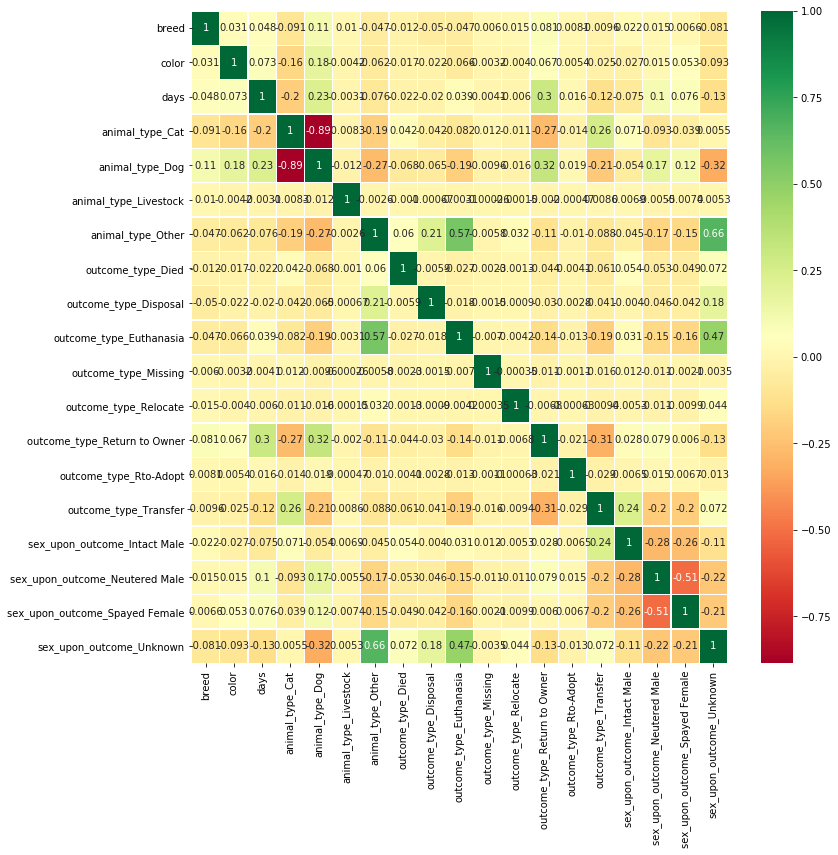

In [58]:
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(12,12)
plt.show()

#### Видно сильную корреляцию между animal_type = other и sex_upon_outcome_Unknown. Тем не менее не стану удалять удалять значения sex_upon_outcome_Unknown


### Переведу в индекс animal_id

In [59]:
df.count()

animal_id                         78244
breed                             78244
color                             78244
days                              78244
animal_type_Cat                   78244
animal_type_Dog                   78244
animal_type_Livestock             78244
animal_type_Other                 78244
outcome_type_Died                 78244
outcome_type_Disposal             78244
outcome_type_Euthanasia           78244
outcome_type_Missing              78244
outcome_type_Relocate             78244
outcome_type_Return to Owner      78244
outcome_type_Rto-Adopt            78244
outcome_type_Transfer             78244
sex_upon_outcome_Intact Male      78244
sex_upon_outcome_Neutered Male    78244
sex_upon_outcome_Spayed Female    78244
sex_upon_outcome_Unknown          78244
dtype: int64

In [60]:
df.animal_id.nunique()

70848

#### Выходит некоторые животные побывали не один раз в этом приюте

Сначала просто удалю дубликаты строк

In [61]:
df.drop_duplicates(inplace=True)
df.count()

animal_id                         75425
breed                             75425
color                             75425
days                              75425
animal_type_Cat                   75425
animal_type_Dog                   75425
animal_type_Livestock             75425
animal_type_Other                 75425
outcome_type_Died                 75425
outcome_type_Disposal             75425
outcome_type_Euthanasia           75425
outcome_type_Missing              75425
outcome_type_Relocate             75425
outcome_type_Return to Owner      75425
outcome_type_Rto-Adopt            75425
outcome_type_Transfer             75425
sex_upon_outcome_Intact Male      75425
sex_upon_outcome_Neutered Male    75425
sex_upon_outcome_Spayed Female    75425
sex_upon_outcome_Unknown          75425
dtype: int64

Найду животных с одним и тем же ID

In [62]:
df[df['animal_id'].duplicated(keep=False)].sort_values(by='animal_id').head(10)

,animal_id,breed,color,days,animal_type_Cat,animal_type_Dog,animal_type_Livestock,animal_type_Other,outcome_type_Died,outcome_type_Disposal,outcome_type_Euthanasia,outcome_type_Missing,outcome_type_Relocate,outcome_type_Return to Owner,outcome_type_Rto-Adopt,outcome_type_Transfer,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown
7055,A006100,1959,523,2555,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
73490,A006100,1959,523,3650,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
6968,A006100,1959,523,2190,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
11161,A245945,1261,402,5110,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
36480,A245945,1261,402,5475,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
31362,A282897,937,22,4745,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
12527,A282897,937,22,4380,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
17269,A287017,658,58,4745,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
36172,A287017,658,58,5110,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
27129,A304036,937,155,4745,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Видно, что A006100 убегал от хозяев три раза. Ну ладно, переведу в индекс эту колонку

In [63]:
df.set_index('animal_id', inplace=True)
df.index.name = None
df.head()

,breed,color,days,animal_type_Cat,animal_type_Dog,animal_type_Livestock,animal_type_Other,outcome_type_Died,outcome_type_Disposal,outcome_type_Euthanasia,outcome_type_Missing,outcome_type_Relocate,outcome_type_Return to Owner,outcome_type_Rto-Adopt,outcome_type_Transfer,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown
A684346,937,321,14,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
A666430,255,474,365,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
A675708,1613,119,365,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
A680386,1468,463,3285,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
A683115,253,122,150,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1


### Модель деревья решений (Random Forest) для классификационной задачи

In [64]:
df.shape

(75425, 19)

In [65]:
from sklearn.preprocessing import MinMaxScaler

In [66]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))
np_scaled = min_max_scaler.fit_transform(df)
df_norm = pd.DataFrame(np_scaled)
df_norm.columns = df.columns
df_norm.head()

,breed,color,days,animal_type_Cat,animal_type_Dog,animal_type_Livestock,animal_type_Other,outcome_type_Died,outcome_type_Disposal,outcome_type_Euthanasia,outcome_type_Missing,outcome_type_Relocate,outcome_type_Return to Owner,outcome_type_Rto-Adopt,outcome_type_Transfer,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown
0,0.440527,0.612595,0.001534,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.119887,0.904580,0.040000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.758345,0.227099,0.040000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.690174,0.883588,0.360000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.118947,0.232824,0.016438,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [67]:
df_norm.iloc[:,7:15].head()

,outcome_type_Died,outcome_type_Disposal,outcome_type_Euthanasia,outcome_type_Missing,outcome_type_Relocate,outcome_type_Return to Owner,outcome_type_Rto-Adopt,outcome_type_Transfer
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [68]:
output_y = df_norm.iloc[:,7:15]

In [69]:
input_x = df_norm

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_x.drop(df_norm.iloc[:,7:15], axis=1), output_y, test_size=0.2)

In [71]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

No handles with labels found to put in legend.


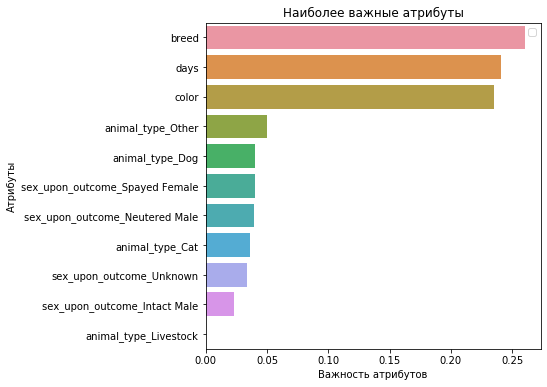

In [72]:
headers = list(X_train.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

In [73]:
from sklearn.metrics import classification_report

In [74]:
model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))

model.score(X_test, y_test)

C:\Users\aekom\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aekom\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aekom\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.32      0.05      0.08       147
           1       0.44      0.06      0.11        64
           2       0.78      0.51      0.62      1205
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         5
           5       0.42      0.28      0.34      2677
           6       0.00      0.00      0.00        32
           7       0.68      0.57      0.62      4707

   micro avg       0.62      0.46      0.53      8846
   macro avg       0.33      0.18      0.22      8846
weighted avg       0.61      0.46      0.52      8846
 samples avg       0.27      0.27      0.27      8846



0.6115346370566788

Получается, что точность равна 60%. Не густо. Вероятно это из-за того, что применил label encoder

### PCA (тут запутался). Если есть возможность, скиньте ссылку на ваше решение цуликом. В целом хочу посмотреть как это работает

In [75]:
from sklearn.decomposition import PCA

In [76]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_norm) # Вот тут нужно дропать таргет-значения?
projected_x = pd.DataFrame(data = principalComponents,
                           columns = ['atribute_1', 'atribute_2'])

In [77]:
projected_x.shape

(75425, 2)

In [78]:
output_y.shape # взял выше

(75425, 8)

In [79]:
input_x = pd.merge(projected_x, output_y, left_index=True, right_index=True)
input_x.head()

,atribute_1,atribute_2,outcome_type_Died,outcome_type_Disposal,outcome_type_Euthanasia,outcome_type_Missing,outcome_type_Relocate,outcome_type_Return to Owner,outcome_type_Rto-Adopt,outcome_type_Transfer
0,1.111165,-0.062491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.306355,0.762125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.682361,-0.628463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.455677,-0.645557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.350927,0.013724,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [84]:
input_x.iloc[:, :2].head()

,atribute_1,atribute_2
0,1.111165,-0.062491
1,-0.306355,0.762125
2,-0.682361,-0.628463
3,-0.455677,-0.645557
4,0.350927,0.013724


In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_x.drop(input_x.iloc[:, :2], axis=1), output_y, test_size=0.2)

In [86]:
model=RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier()

In [87]:
model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))

model.score(X_test, y_test)

C:\Users\aekom\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aekom\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00        61
           2       1.00      1.00      1.00      1217
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00      2664
           6       1.00      1.00      1.00        31
           7       1.00      1.00      1.00      4609

   micro avg       1.00      1.00      1.00      8724
   macro avg       1.00      1.00      1.00      8724
weighted avg       1.00      1.00      1.00      8724
 samples avg       0.58      0.58      0.58      8724



1.0